# Installation

## IRIS Native SDK/DB-API instalation

In [1]:
# Download the InterSystems IRIS Native SDK/DB-API library for Python
import requests
url = 'https://github.com/intersystems-community/iris-driver-distribution/blob/main/DB-API/intersystems_irispython-3.2.0-py3-none-any.whl?raw=true'
r = requests.get(url, allow_redirects=True)
print(f"File size: {open('../intersystems_irispython-3.2.0-py3-none-any.whl', 'wb').write(r.content)} bytes")

File size: 104198 bytes


In [2]:
# Check if the file was download and is present in the current dir
import glob
for files in glob.glob("../*.whl"):
    print(files)

..\intersystems_irispython-3.2.0-py3-none-any.whl


In [3]:
# Install the library
!pip install --force-reinstall ../intersystems_irispython-3.2.0-py3-none-any.whl

Processing c:\users\jrper\dev\notebooks\intersystems-iris-notebooks\cloud_sql\intersystems_irispython-3.2.0-py3-none-any.whl
  Attempting uninstall: intersystems-irispython
    Found existing installation: intersystems-irispython 3.2.0
    Uninstalling intersystems-irispython-3.2.0:
      Successfully uninstalled intersystems-irispython-3.2.0


## Other libs

In [4]:
!pip install pandas sqlalchemy-iris

# IRIS connection

In [5]:
import iris
from sqlalchemy import create_engine, text, DateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# InterSystems IRIS Cloud SQL connection parameters
# You can define these parameters using the following environment 
# variables or you can hardcode them, just be aware to not publish 
# your credntials in public repos like github for instance
args = {
    'hostname': os.getenv("ISC_CLOUD_SQL_HOSTNAME"), 
    'port': os.getenv("ISC_CLOUD_SQL_PORT"),
    'namespace': os.getenv("ISC_CLOUD_SQL_NAMESPACE"), 
    'username': os.getenv("ISC_CLOUD_SQL_USER"),  
    'password': os.getenv("ISC_CLOUD_SQL_PWD") 
}

In [7]:
# Create a sqlalchemy connection to IRIS
engine = create_engine(f"iris://{args['username']}:{args['password']}@{args['hostname']}:{args['port']}/{args['namespace']}")
conn = engine.connect()

C:\Users\jrper\dev\venv\Lib\site-packages\sqlalchemy_iris\base.py:888: SAWarning: There are no access to %Dictionary, may be required for some advanced features, such as Calculated fields, and include columns in indexes                
  util.warn(


# Data ingestion

In [8]:
# Load the trainning dataset from the CSV file, enforcing pandas to interpret columns tpep_pickup_datetime and tpep_dropoff_datetime as timestramp
train_df = pd.read_csv(
    "./yellow_tripdata_15k-train.csv", 
    parse_dates=[1,2]
)
train_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-06-06 23:01:00,2022-06-06 23:11:00,1,2.22,1,N,164,211,1,9.5,0.50,0.5,2.66,0.00,0.3,15.96,2.5,0.00
1,1,2022-06-06 16:20:00,2022-06-06 16:25:00,1,0.90,1,N,239,239,2,5.5,3.50,0.5,0.00,0.00,0.3,9.80,2.5,0.00
2,1,2022-06-05 17:08:00,2022-06-05 17:24:00,1,2.40,1,N,229,143,2,12.5,2.50,0.5,0.00,0.00,0.3,15.80,2.5,0.00
3,2,2022-06-09 09:33:00,2022-06-09 09:54:00,2,3.65,1,N,142,249,1,16.0,0.00,0.5,2.00,0.00,0.3,21.30,2.5,0.00
4,1,2022-06-01 11:22:00,2022-06-01 11:22:00,1,0.00,1,N,145,145,2,2.5,0.00,0.5,0.00,0.00,0.3,3.30,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15271,2,2022-06-03 09:54:00,2022-06-03 10:06:00,1,1.55,1,N,186,137,2,9.5,0.00,0.5,0.00,0.00,0.3,12.80,2.5,0.00
15272,2,2022-06-01 12:39:00,2022-06-01 13:03:00,1,2.57,1,N,233,142,1,15.5,0.00,0.5,3.76,0.00,0.3,22.56,2.5,0.00
15273,2,2022-06-03 11:25:00,2022-06-03 11:40:00,1,1.74,1,N,186,50,1,11.0,0.00,0.5,2.86,0.00,0.3,17.16,2.5,0.00
15274,2,2022-06-08 19:22:00,2022-06-08 19:27:00,1,0.77,1,N,162,107,2,5.0,1.00,0.5,0.00,0.00,0.3,9.30,2.5,0.00


In [9]:
# Uses the sqlalchmey connection to create a table in InterSystems IRIS Cloud SQL and ingest the training dataset
train_df.to_sql(
    name='yellow_tripdata_train', # the table name that is going to be created in IRIS
    con=conn, 
    if_exists='replace', 
    index=False
)

-1

In [10]:
# Check how many records was ingested in IRIS database
# Note the use of the default IRIS schema SQLUser, 
# as we didn't define a schema when ingesting the dataset into a table in IRIS
sql_query = f"""
SELECT count(*) from SQLUser.yellow_tripdata_train
"""
result = conn.execute(text(sql_query))
print(f"Imported {result.first()[0]} results")

Imported 15276 results


In [11]:
# Retrive the first and last 5 records from the trainning dataset ingested in IRIS
sql = f"""
select top 5 * from SQLUser.yellow_tripdata_train order by ID
union
select top 5 * from SQLUser.yellow_tripdata_train order by ID desc
"""
pd.read_sql(sql, conn)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-06-06 23:01:00,2022-06-06 23:11:00,1,2.22,1,N,164,211,1,9.5,0.50,0.5,2.66,0.00,0.3,15.96,2.5,0.00
1,1,2022-06-06 16:20:00,2022-06-06 16:25:00,1,0.90,1,N,239,239,2,5.5,3.50,0.5,0.00,0.00,0.3,9.80,2.5,0.00
2,1,2022-06-05 17:08:00,2022-06-05 17:24:00,1,2.40,1,N,229,143,2,12.5,2.50,0.5,0.00,0.00,0.3,15.80,2.5,0.00
3,2,2022-06-09 09:33:00,2022-06-09 09:54:00,2,3.65,1,N,142,249,1,16.0,0.00,0.5,2.00,0.00,0.3,21.30,2.5,0.00
4,1,2022-06-01 11:22:00,2022-06-01 11:22:00,1,0.00,1,N,145,145,2,2.5,0.00,0.5,0.00,0.00,0.3,3.30,0.0,0.00
5,1,2022-06-05 20:23:00,2022-06-05 20:45:00,1,7.20,1,N,138,152,2,23.0,1.75,0.5,0.00,6.55,0.3,32.10,0.0,1.25
6,2,2022-06-08 19:22:00,2022-06-08 19:27:00,1,0.77,1,N,162,107,2,5.0,1.00,0.5,0.00,0.00,0.3,9.30,2.5,0.00
7,2,2022-06-03 11:25:00,2022-06-03 11:40:00,1,1.74,1,N,186,50,1,11.0,0.00,0.5,2.86,0.00,0.3,17.16,2.5,0.00
8,2,2022-06-01 12:39:00,2022-06-01 13:03:00,1,2.57,1,N,233,142,1,15.5,0.00,0.5,3.76,0.00,0.3,22.56,2.5,0.00
9,2,2022-06-03 09:54:00,2022-06-03 10:06:00,1,1.55,1,N,186,137,2,9.5,0.00,0.5,0.00,0.00,0.3,12.80,2.5,0.00


In [12]:
# Load the validation dataset from the CSV file
validate_df = pd.read_csv(
    "./yellow_tripdata_15k-validate.csv", 
    parse_dates=[1,2]
)
validate_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-06-04 17:56:00,2022-06-04 18:56:00,1,21.77,2,N,132,142,4,-52.0,0.0,-0.5,0.00,-6.55,-0.3,-63.10,-2.5,-1.25
1,1,2022-06-01 20:31:00,2022-06-01 20:50:00,1,3.00,1,N,236,100,2,14.0,3.0,0.5,0.00,0.00,0.3,17.80,2.5,0.00
2,2,2022-06-08 23:54:00,2022-06-09 00:04:00,4,3.41,1,N,140,234,2,12.0,0.5,0.5,0.00,0.00,0.3,15.80,2.5,0.00
3,2,2022-06-02 17:14:00,2022-06-02 17:17:00,2,0.32,1,N,239,239,1,4.0,1.0,0.5,2.00,0.00,0.3,10.30,2.5,0.00
4,1,2022-06-03 06:11:00,2022-06-03 06:21:00,1,2.30,1,N,142,162,2,9.0,2.5,0.5,0.00,0.00,0.3,12.30,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15632,1,2022-06-01 07:23:00,2022-06-01 07:30:00,1,0.90,1,N,162,230,2,6.5,2.5,0.5,0.00,0.00,0.3,9.80,2.5,0.00
15633,2,2022-06-08 15:56:00,2022-06-08 16:08:00,1,1.57,1,N,234,186,1,9.0,0.0,0.5,2.46,0.00,0.3,14.76,2.5,0.00
15634,2,2022-06-08 15:21:00,2022-06-08 15:46:00,1,3.80,1,N,45,162,1,18.0,0.0,0.5,4.26,0.00,0.3,25.56,2.5,0.00
15635,1,2022-06-04 01:18:00,2022-06-04 01:23:00,1,1.60,1,N,229,141,1,6.5,3.0,0.5,2.05,0.00,0.3,12.35,2.5,0.00


In [13]:
# Ingest the validating dataset into InterSystems IRIS Cloud SQL
validate_df.to_sql(
    name='yellow_tripdata_validate', # the table name that is going to be created in IRIS
    con=conn, 
    if_exists='replace', 
    index=False)

-1

In [14]:
# Check how many records was ingested in IRIS database
sql_query = f"""
SELECT count(*) from SQLUser.yellow_tripdata_validate
"""
result = conn.execute(text(sql_query))
print(f"Imported {result.first()[0]} results")

Imported 15637 results


In [15]:
# Retrive the first and last 5 records from the validation dataset ingested in IRIS
sql = f"""
SELECT top 5 * from SQLUser.yellow_tripdata_validate order by ID
union
SELECT top 5 * from SQLUser.yellow_tripdata_validate order by ID desc
"""
pd.read_sql(sql, conn)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-06-04 17:56:00,2022-06-04 18:56:00,1,21.77,2,N,132,142,4,-52.0,0.0,-0.5,0.00,-6.55,-0.3,-63.10,-2.5,-1.25
1,1,2022-06-01 20:31:00,2022-06-01 20:50:00,1,3.00,1,N,236,100,2,14.0,3.0,0.5,0.00,0.00,0.3,17.80,2.5,0.00
2,2,2022-06-08 23:54:00,2022-06-09 00:04:00,4,3.41,1,N,140,234,2,12.0,0.5,0.5,0.00,0.00,0.3,15.80,2.5,0.00
3,2,2022-06-02 17:14:00,2022-06-02 17:17:00,2,0.32,1,N,239,239,1,4.0,1.0,0.5,2.00,0.00,0.3,10.30,2.5,0.00
4,1,2022-06-03 06:11:00,2022-06-03 06:21:00,1,2.30,1,N,142,162,2,9.0,2.5,0.5,0.00,0.00,0.3,12.30,2.5,0.00
5,2,2022-06-08 14:57:00,2022-06-08 15:09:00,1,1.48,1,N,236,237,1,9.5,0.0,0.5,2.56,0.00,0.3,15.36,2.5,0.00
6,1,2022-06-04 01:18:00,2022-06-04 01:23:00,1,1.60,1,N,229,141,1,6.5,3.0,0.5,2.05,0.00,0.3,12.35,2.5,0.00
7,2,2022-06-08 15:21:00,2022-06-08 15:46:00,1,3.80,1,N,45,162,1,18.0,0.0,0.5,4.26,0.00,0.3,25.56,2.5,0.00
8,2,2022-06-08 15:56:00,2022-06-08 16:08:00,1,1.57,1,N,234,186,1,9.0,0.0,0.5,2.46,0.00,0.3,14.76,2.5,0.00
9,1,2022-06-01 07:23:00,2022-06-01 07:30:00,1,0.90,1,N,162,230,2,6.5,2.5,0.5,0.00,0.00,0.3,9.80,2.5,0.00


# Create your model

In [16]:
# Make sure that there is no previous ML model in IRIS called TipPrediction
sql = """
drop model TipPrediction
"""
try:
    result = conn.execute(text(sql))
    print("Model removed.")
except:
    print("Can't drop the model - probably it doesn't exist.")

Model removed.


In [17]:
# Tells IRIS to create a ML model called 'TipPrediction' to predict the value of the target column 'tip_amount', 
# based on features (columns) within the training table 'SQLUser.yellow_tripdata_train'.
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Create
sql = """
create model TipPrediction predicting (tip_amount FLOAT) from SQLUser.yellow_tripdata_train
"""
conn.execute(text(sql))

In [18]:
# Get the ML models hosted in IRIS
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_Models
sql = """
select * from INFORMATION_SCHEMA.ML_MODELS
"""
pd.read_sql(sql, conn)

,MODEL_NAME,DESCRIPTION,PREDICTING_COLUMN_NAME,PREDICTING_COLUMN_TYPE,WITH_COLUMNS,CREATE_TIMESTAMP,DEFAULT_TRAINED_MODEL_NAME,DEFAULT_SETTINGS,DEFAULT_TRAINING_QUERY
0,TipPrediction,Model TipPrediction created via SQL by user SQ...,tip_amount,DOUBLE,"VendorID:BIGINT, tpep_pickup_datetime:TIMESTAM...",2023-10-07 21:30:28.377,None,None,SELECT * FROM SQLUser . yellow_tripdata_train


# Train your model

In [19]:
# Let IRIS train the TipPrediction ML model using the tranning dataset SQLUser.yellow_tripdata_train 
# and label it as TipPredictionTranined
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Train
sql = """
train model TipPrediction as TipPredictionTranined
"""
conn.execute(text(sql))

In [20]:
# Get information about trannings performed by IRIS in thier ML models
# Note that IRIS used the H2O ML services as ML provider
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_TrainedModels
sql = """
select * from INFORMATION_SCHEMA.ML_TRAINED_MODELS
"""
result = conn.execute(text(sql))
pd.read_sql(sql, conn)

,MODEL_NAME,TRAINED_MODEL_NAME,PROVIDER,TRAINED_TIMESTAMP,MODEL_TYPE,MODEL_INFO
0,TipPrediction,TipPredictionTranined,H2O,2023-10-07 21:32:37.627,regression,None


As you can see in column "MODEL_TYPE", the IRIS IntegratedML engine choose a **regression** model.

This was due we choose a float type column as target column to the model.

In [21]:
# Get detailed information about trannings performed by IRIS in thier ML models
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_TrainingRuns
sql = """
select * from INFORMATION_SCHEMA.ML_TRAINING_RUNS
"""
pd.read_sql(sql, conn)

,MODEL_NAME,TRAINING_RUN_NAME,PROVIDER,START_TIMESTAMP,COMPLETED_TIMESTAMP,TRAINING_DURATION,RUN_STATUS,STATUS_CODE,LOG,SETTINGS,ML_CONFIGURATION_NAME,TRAINING_RUN_QUERY
0,TipPrediction,TipPredictionTranined,H2O,2023-10-07 21:30:28.944,2023-10-07 21:32:37.627,128.683,completed,1,2023-10-07 21:30:28.947 Starting Training for ...,None,%H2O,SELECT * FROM SQLUser . yellow_tripdata_train


# Validate your model

In [22]:
# Tells to IRIS to run the trained modlel TipPredictionTranined using the validation 
# dataset SQLUser.yellow_tripdata_validate in order to collect the performance metrics
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Validate
sql = """
validate model TipPrediction use TipPredictionTranined from SQLUser.yellow_tripdata_validate
"""
conn.execute(text(sql))

In [23]:
# Get genereal information about the validations executed by IRIS in their hosted ML models
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_ValidationRuns
sql = """
select * from INFORMATION_SCHEMA.ML_VALIDATION_RUNS
"""
pd.read_sql(sql, conn)

,MODEL_NAME,TRAINED_MODEL_NAME,VALIDATION_RUN_NAME,START_TIMESTAMP,COMPLETED_TIMESTAMP,VALIDATION_DURATION,RUN_STATUS,STATUS_CODE,LOG,SETTINGS,VALIDATION_RUN_QUERY
0,TipPrediction,TipPredictionTranined,TipPredictionTranined_v1,2023-10-07 21:32:38.827,2023-10-07 21:32:40.767,1.94,completed,1,2023-10-07 21:32:38.827: Preparing validation ...,None,"SELECT tip_amount,VendorID,tpep_pickup_datetim..."


In [24]:
# Get the value of performance metrics of validations executed by IRIS
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_ValidationMetrics
sql = """
select * from INFORMATION_SCHEMA.ML_VALIDATION_METRICS
"""
pd.read_sql(sql, conn)

,MODEL_NAME,TRAINED_MODEL_NAME,VALIDATION_RUN_NAME,METRIC_NAME,METRIC_VALUE,TARGET_VALUE
0,TipPrediction,TipPredictionTranined,TipPredictionTranined_v1,MSE,0.37,None
1,TipPrediction,TipPredictionTranined,TipPredictionTranined_v1,RMSE,0.61,None
2,TipPrediction,TipPredictionTranined,TipPredictionTranined_v1,Variance,9.83,None
3,TipPrediction,TipPredictionTranined,TipPredictionTranined_v1,R2,0.96,None


# Make predictions

In [25]:
# Use the predict() function to execute prediction using the ML model TipPredictionTranined
# This function automatically retrieves all need model features from the columns available 
# in the query - only the table SQLUser.yellow_tripdata_validate in this case
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Predict
sql = """
select 
      top 100
      predict(TipPrediction use TipPredictionTranined) as prediction, 
      tip_amount, 
      * 
    from
      SQLUser.yellow_tripdata_validate
"""
pd.read_sql(sql, conn)

,prediction,tip_amount,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,-0.19249269784475131,0.00,2,2022-06-04 17:56:00,2022-06-04 18:56:00,1,21.77,2,N,132,...,4,-52.0,0.0,-0.5,0.00,-6.55,-0.3,-63.10,-2.5,-1.25
1,-0.21144097939152431,0.00,1,2022-06-01 20:31:00,2022-06-01 20:50:00,1,3.00,1,N,236,...,2,14.0,3.0,0.5,0.00,0.00,0.3,17.80,2.5,0.00
2,-0.14968142494689723,0.00,2,2022-06-08 23:54:00,2022-06-09 00:04:00,4,3.41,1,N,140,...,2,12.0,0.5,0.5,0.00,0.00,0.3,15.80,2.5,0.00
3,1.8655683324841303,2.00,2,2022-06-02 17:14:00,2022-06-02 17:17:00,2,0.32,1,N,239,...,1,4.0,1.0,0.5,2.00,0.00,0.3,10.30,2.5,0.00
4,-0.2648828772891152,0.00,1,2022-06-03 06:11:00,2022-06-03 06:21:00,1,2.30,1,N,142,...,2,9.0,2.5,0.5,0.00,0.00,0.3,12.30,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.884791261012429,2.00,2,2022-06-05 11:46:00,2022-06-05 11:52:00,1,0.81,1,N,234,...,1,5.5,0.0,0.5,2.00,0.00,0.3,10.80,2.5,0.00
96,2.8297907502285966,2.86,2,2022-06-08 10:58:00,2022-06-08 11:14:00,1,1.44,1,N,48,...,1,11.0,0.0,0.5,2.86,0.00,0.3,17.16,2.5,0.00
97,2.7492893226168427,2.86,2,2022-06-09 10:16:00,2022-06-09 10:32:00,1,2.03,1,N,4,...,1,11.0,0.0,0.5,2.86,0.00,0.3,17.16,2.5,0.00
98,4.1094848214937105,4.44,2,2022-06-09 14:39:00,2022-06-09 14:55:00,1,1.99,1,N,162,...,1,11.5,0.0,0.5,4.44,0.00,0.3,19.24,2.5,0.00


# Prediction vs actual chart

In [26]:
# Retrieves all predictions from the validation dataset in order to plot the 'Prediction vs Acutal' chart
sql = """
select 
      cast(predict(TipPrediction use TipPredictionTranined) as double) as prediction, 
      tip_amount
    from
      SQLUser.yellow_tripdata_validate
"""
result = conn.exec_driver_sql(sql)
y = []
predicted = []
for row in result:
    y.append(row[1])
    predicted.append(row[0])
y = np.asarray(y)
predicted = np.asarray(predicted)

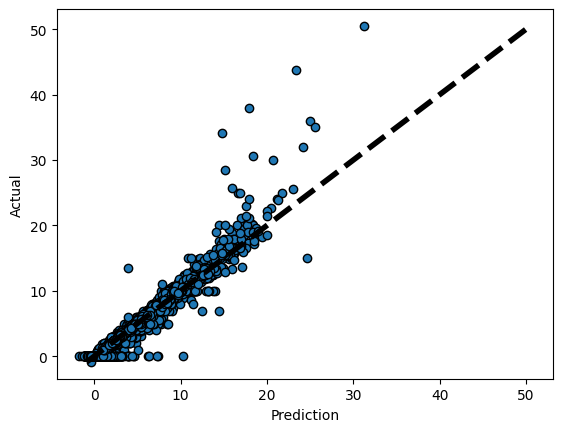

In [27]:
# Plot the 'Prediction vs Acutal' chart
# As near the diagonal line, better is the prediction.
fig, ax = plt.subplots()
ax.scatter(predicted, y, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
plt.show()

# Releasing resources

In [28]:
conn.close()
engine.dispose()

# References

https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=BPYNAT_refapi#BPYNAT_refapi_irispackage_createconn

https://community.intersystems.com/post/sqlalchemy-easiest-way-use-python-and-sql-iriss-databases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html

https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML

https://scikit-learn.org/0.19/auto_examples/plot_cv_predict.html